In [1]:
import os
import random
import numpy as np
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())  # GPU 확인
print(tf.config.list_physical_devices("GPU"))  # GPU 인식 여부 확인

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8337198338127599241
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14234419200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14153127608472165770
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# GPU 메모리 점진 할당 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["font.family"]="Malgun Gothic"
plt.rcParams["axes.unicode_minus"]=False

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
IMG_SIZE = 86
BATCH_SIZE = 32  # 배치 크기 16 -> 32로 변경
DATA_PATH = "../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,  # flip off로 변경
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [6]:
model=Sequential()

model.add(Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(96, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))  # 0.4 -> 0.3 으로 변경
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(learning_rate=0.0005),  # 조정됨
            loss="binary_crossentropy", metrics=["accuracy"])

In [7]:
esc=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history=model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks=[esc])

Epoch 1/20
1200/1200 [==============================] - 674s 544ms/step - loss: 0.3546 - accuracy: 0.9011 - val_loss: 0.7812 - val_accuracy: 0.6724
Epoch 2/20
1200/1200 [==============================] - 75s 62ms/step - loss: 0.1320 - accuracy: 0.9522 - val_loss: 0.3646 - val_accuracy: 0.8291
Epoch 3/20
1200/1200 [==============================] - 79s 65ms/step - loss: 0.0977 - accuracy: 0.9661 - val_loss: 0.3551 - val_accuracy: 0.8403
Epoch 4/20
1200/1200 [==============================] - 71s 59ms/step - loss: 0.0788 - accuracy: 0.9736 - val_loss: 0.2891 - val_accuracy: 0.8821
Epoch 5/20
1200/1200 [==============================] - 73s 61ms/step - loss: 0.0601 - accuracy: 0.9795 - val_loss: 0.4819 - val_accuracy: 0.8506
Epoch 6/20
1200/1200 [==============================] - 74s 62ms/step - loss: 0.0535 - accuracy: 0.9830 - val_loss: 0.3509 - val_accuracy: 0.8659
Epoch 7/20
1200/1200 [==============================] - 77s 64ms/step - loss: 0.0493 - accuracy: 0.9834 - val_loss: 0.4570

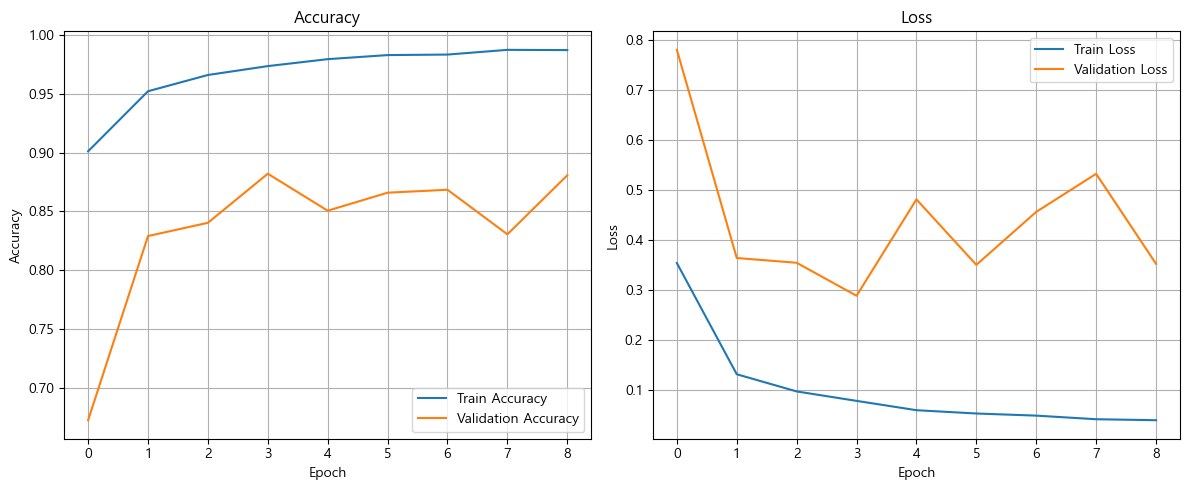

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("../../results/images/readjusted_training_plot_after_bayesian.png")
plt.show()

In [9]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)

with open("../../results/reports/readjusted_classification_report_after_bayesian.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

      closed       0.83      0.98      0.90      4800
        open       0.97      0.79      0.87      4800

    accuracy                           0.89      9600
   macro avg       0.90      0.89      0.88      9600
weighted avg       0.90      0.89      0.88      9600



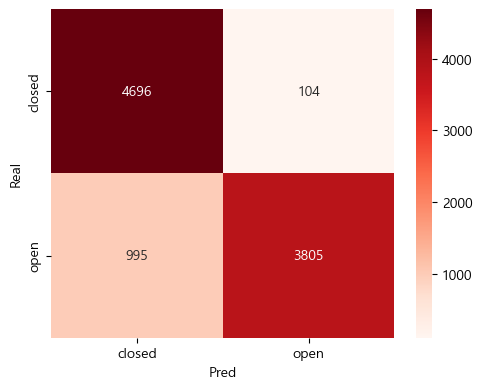

In [10]:
conf_metrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_metrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/readjusted_confusion_matrix.png")
plt.show()

In [11]:
os.makedirs("../../src/models/04_Adjusted_Model", exist_ok=True)
model.save("../../src/models/04_Adjusted_Model/readjusted_model.keras")

- 학습 그래프  
  - Train Accuracy: 거의 0.99 도달 (완전 학습됨)  
  - Val Accuracy: 최고 0.88 ~ 0.89 -> 출렁임 존재  
  - Train Loss: 안정적으로 감소  
  - Val Loss: 오락가락 출렁임 -> 과적합  
Epoch 4 전후가 가장 안정적 -> 그 이후는 overfitting이 발생하면서 성능 저하됨  

- "눈이 감겼다(closed)"는 걸 잘 맞춤  
- "눈이 열렸다(open)"는 걸 잘못 closed로 오해함 (False Negative 다수 발생)  

- 다음 재조정  
  - Dropout 0.4 또는 0.5로 늘리기  
  - Dense 노드 수 줄이기  
  - EarlyStopping 빼고 10회 정도 학습  
  - l2 정규화 적용  